In [1]:
#Distributions and Modules
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch import distributions
import pandas as pd
import numpy as np
from torch import optim

In [2]:
def Normalization(df):
    df.iloc[:,2:]= df.iloc[:,2:].apply(lambda x: ((x-x.mean()) / (x.std())))
    return df

In [3]:
def preprocessing(path):
#    gamma = 0.9
    df = pd.read_csv(path, header=None, delimiter=' ')
    
    #Normalize the data
    df = Normalization(df)
    
    #Drop the columns which has all values as Nan
    df.dropna(axis=1, how='all', inplace=True)
    
#     #Get Rewards for each time step : 0 except last time step where reward is -100
#     df['Counter'] = df.index
#     lastRowIndex = df.groupby(0).last().Counter.tolist()
#     df['reward'] = df['Counter'].apply(lambda x : -100 if x in lastRowIndex else 0 )
#     df.drop(columns=['Counter'],inplace=True)
    
    #Rename columns
    df.rename(columns={0: "machine", 1: "time"}, inplace=True)
    
    #Calculate Monte Carlo Value for each row
    df1 = df.groupby('machine').last()[['time']].reset_index()
    df = pd.merge(df, df1, on = 'machine', how = 'left').rename(columns ={'time_x':'time','time_y':'lastTimeStamp'})
    #df['MC_Val'] = (gamma ** (df['lastTimeStamp'] - df['time'] )) * (-100)
    df['MC_Val'] = (df['lastTimeStamp'] - df['time'] )
    df = df.drop(columns='lastTimeStamp')
    
    return df

In [5]:
df = pd.read_csv("HMM_data.csv")

In [10]:
df.drop(df.columns[0], axis=1, inplace=True)

In [11]:
df.head()

,machine,time,2,3,5,6,7,8,9,10,...,15,16,17,18,19,20,21,24,25,Return
0,1,1,-0.315972,-1.372920,0.999976,-1.721684,-0.134252,-0.925914,0.999976,0.14168,...,-0.266460,0.334254,-1.058865,-0.269065,-0.603801,0.999976,-0.781691,1.348460,1.194398,21037.935596
1,1,2,0.872701,-1.031695,0.999976,-1.061754,0.211523,-0.643710,0.999976,0.14168,...,-0.191578,1.174871,-0.363637,-0.642829,-0.275845,0.999976,-0.781691,1.016503,1.236892,20887.935596
2,1,3,-1.961827,1.015652,0.999976,-0.661797,-0.413156,-0.525940,0.999976,0.14168,...,-1.015279,1.364688,-0.919819,-0.551616,-0.649128,0.999976,-2.073044,0.739873,0.503411,20737.935596
3,1,4,0.324083,-0.008022,0.999976,-0.661797,-1.261284,-0.784812,0.999976,0.14168,...,-1.539452,1.961255,-0.224592,-0.520163,-1.971617,0.999976,-0.781691,0.352590,0.777773,20587.935596
4,1,5,-0.864590,-0.690471,0.999976,-0.621801,-1.251498,-0.301511,0.999976,0.14168,...,-0.977838,1.052846,-0.780774,-0.521736,-0.339837,0.999976,-0.136014,0.463242,1.059526,20437.935596


## We have added the reward and Val column. We will be using the Val column for the Monte Carlo return gamma**(T-t)  *  -100

## Now lets build the Neural network for the predictron

In [12]:
#Neural network for Observation - Hidden State

In [13]:
class NN_OH(nn.Module):
    def __init__(self, input_size, out_size):
        super(NN_OH,self).__init__()
        self.fc1 = nn.Linear(input_size,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,64)
        self.fc4 = nn.Linear(64,out_size)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x), dim=1)
        return x

In [14]:
#Neural network for Hidden State - Reward, Gamma, Lambda

In [15]:
class NN_reward(nn.Module):
    def __init__(self, input_size):
        super(NN_reward,self).__init__()
        self.fc1 = nn.Linear(input_size,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,3)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
#Neural network for Hidden State - Value
class NN_val(nn.Module):
    def __init__(self, input_size):
        super(NN_val,self).__init__()
        self.fc1 = nn.Linear(input_size,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,1)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
##Neural Network which will take my current hidden state to the next hidden state

In [18]:
class NN_HH(nn.Module):
    def __init__(self, input_size):
        super(NN_HH,self).__init__()
        self.fc1 = nn.Linear(input_size,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,64)
        self.fc4 = nn.Linear(64,input_size)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x), dim =1)
        return x

In [19]:
#Now we have all the required neural networks for the predictron. Lets build the Predictron

class Predictronv3(nn.Module):
    def __init__(self, obs_size, hid_size, k=10):
        super(Predictronv3,self).__init__()
        
        #Instantiate Neural Network for Observation-Hidden State
        self.OH = NN_OH(obs_size, hid_size)
        
        #Instantiate Neural Network for Hidden State - Reward, Value
        self.HR = NN_reward(hid_size)
        
        #Instantiate Neural Network for Hidden State - Val
        self.HV = NN_val(hid_size)
        
        #Instantiate Neural Network for Hidden State - Next Hidden State
        self.HH = NN_HH(hid_size)
        
        #K-step return
        self.k = k
        
    def forward(self, x):
        #Predictron core will output the value estimate for the current observation. We will input x (observation) 
        #and get value estimate. This implementation is for a k-step return which can be extended to TD(lambda) return
        
        #First step: Get the Hidden state for the current observation
        
        x = self.OH(x)
        #Get the reward, lambda, gamma for current hidden state
        reward = self.HR(x)[:,0].reshape(-1,1)
        gamma = self.HR(x)[:,1].reshape(-1,1)
        _lambda = self.HR(x)[:,2].reshape(-1,1)
        
        #Get value of the current hidden state
        val = self.HV(x)
        #print(val.shape)
        #Get glk for 0th step
        glk = (1-_lambda)*val + _lambda* reward
        #print(glk.shape)
        
        #Store gamma and lambda as prev lambda
        prev_gamma = gamma
        prev_lambda = _lambda
        
        #Now run the loop for k steps
        for i in range(1, self.k + 1):
            #Move to next hidden step
            x = self.HH(x)
            
            #Get the reward, lambda, gamma for current hidden state
            reward = self.HR(x)[:,0].reshape(-1,1)
            gamma = self.HR(x)[:,1].reshape(-1,1)
            _lambda = self.HR(x)[:,2].reshape(-1,1)
            
            #Get value of the current hidden state
            val = self.HV(x)
            
            #Calculate the lambda return
            glk += (prev_gamma*prev_lambda) * ((1-_lambda)*val + _lambda* reward)
        

        return glk.reshape(-1,1)

In [20]:
def getXY(data):
    x = torch.tensor(data.iloc[:, 2:-1].values).float()
    y_target = torch.tensor(data.iloc[:,-1].values).float()
    y_target = y_target.reshape(-1,1)
    
    return x, y_target

In [21]:
x, y_target = getXY(df)

In [22]:
x.shape

torch.Size([20631, 21])

In [23]:
y_target.shape

torch.Size([20631, 1])

In [25]:
#Defining the loss function and Initialising the Predictron core
k=10
loss_fn = nn.MSELoss() #**#Summation
core = Predictronv3(x.shape[1], 4, k)
optimizer = optim.Adam(core.parameters(), lr = 1e-4) #set to 1e-3

In [26]:
core

Predictronv3(
  (OH): NN_OH(
    (fc1): Linear(in_features=21, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=64, bias=True)
    (fc4): Linear(in_features=64, out_features=4, bias=True)
  )
  (HR): NN_reward(
    (fc1): Linear(in_features=4, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=3, bias=True)
  )
  (HV): NN_val(
    (fc1): Linear(in_features=4, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=1, bias=True)
  )
  (HH): NN_HH(
    (fc1): Linear(in_features=4, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=64, bias=True)
    (fc4): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [27]:
n_epochs = 50 # or whatever
batch_size = 256# or whatever
losses=[]
for epoch in range(n_epochs):

    # x is our input
    permutation = torch.randperm(x.size()[0])

    for i in range(0,x.size()[0], batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x[indices], y_target[indices]

        # in case you wanted a semi-full example
        outputs = core.forward(batch_x)
        loss = loss_fn(outputs,batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print("Loss after:"+str(epoch)+" iterations is :"+ str(loss))

Loss after:0 iterations is :tensor(1.3713e+08, grad_fn=<MseLossBackward>)
Loss after:1 iterations is :tensor(1.7089e+08, grad_fn=<MseLossBackward>)
Loss after:2 iterations is :tensor(1.6720e+08, grad_fn=<MseLossBackward>)
Loss after:3 iterations is :tensor(1.3428e+08, grad_fn=<MseLossBackward>)
Loss after:4 iterations is :tensor(57703628., grad_fn=<MseLossBackward>)
Loss after:5 iterations is :tensor(59418752., grad_fn=<MseLossBackward>)
Loss after:6 iterations is :tensor(36567300., grad_fn=<MseLossBackward>)
Loss after:7 iterations is :tensor(30435990., grad_fn=<MseLossBackward>)
Loss after:8 iterations is :tensor(22525136., grad_fn=<MseLossBackward>)
Loss after:9 iterations is :tensor(24604920., grad_fn=<MseLossBackward>)
Loss after:10 iterations is :tensor(21452720., grad_fn=<MseLossBackward>)
Loss after:11 iterations is :tensor(24313538., grad_fn=<MseLossBackward>)
Loss after:12 iterations is :tensor(15356418., grad_fn=<MseLossBackward>)
Loss after:13 iterations is :tensor(21014024

Text(0.5, 1.0, 'Training Loss for Predictron with 10-step return')

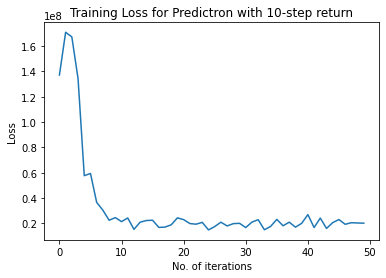

In [28]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("No. of iterations")
plt.ylabel("Loss")
plt.title("Training Loss for Predictron with "+str(k)+"-step return")

In [29]:
for p in core.parameters():
    print(p.shape)

torch.Size([64, 21])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([4, 64])
torch.Size([4])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([3, 64])
torch.Size([3])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([1, 64])
torch.Size([1])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([4, 64])
torch.Size([4])


In [30]:
x

tensor([[-0.3160, -1.3729,  1.0000,  ..., -0.7817,  1.3485,  1.1944],
        [ 0.8727, -1.0317,  1.0000,  ..., -0.7817,  1.0165,  1.2369],
        [-1.9618,  1.0157,  1.0000,  ..., -2.0730,  0.7399,  0.5034],
        ...,
        [ 0.1869, -0.0080,  1.0000,  ...,  3.0924, -2.0818, -3.2924],
        [-0.4988,  1.0157,  1.0000,  ...,  1.1553, -2.9117, -2.0850],
        [-1.4589, -1.7141,  1.0000,  ...,  1.8010, -2.4690, -2.1940]])

## Testing

In [46]:
df_test = preprocessing("../CMAPSSData/test_FD001.txt")

In [47]:
df_test = df_test.groupby('machine').last().reset_index()

In [48]:
df_test.shape

(100, 24)

In [49]:
df_test.head()

,machine,time,2,3,5,6,7,8,9,10,...,15,16,17,18,19,20,21,24,25,MC_Val
0,1,31,-0.267320,1.345990,0.999962,0.261692,-1.374941,-0.870977,0.999962,0.175653,...,-0.950423,0.075544,-0.193640,-0.867422,-0.808153,0.999962,0.347263,-0.582306,0.231303,0
1,2,49,0.822260,-0.354514,0.999962,0.186860,-0.301643,0.911237,0.999962,0.175653,...,1.295424,-0.013802,0.333283,-1.182480,0.849935,0.999962,-1.274039,-0.582306,-0.879011,0
2,3,126,-0.721311,1.345990,0.999962,1.010010,0.329943,2.116325,0.999962,0.175653,...,2.367305,-1.639885,1.211488,-0.734921,-0.480672,0.999962,1.968564,0.264669,-0.733981,0
3,4,106,0.549865,1.345990,0.999962,0.760570,1.285318,0.320655,0.999962,0.175653,...,1.193340,0.236365,0.684565,-0.520956,1.294619,0.999962,1.968564,-2.205674,-0.922996,0
4,5,98,-0.585114,-1.374816,0.999962,-0.511569,0.367918,2.186597,0.999962,0.175653,...,0.223542,-1.336111,1.387129,-1.296332,0.356990,0.999962,1.157913,-1.005793,0.902961,0


In [50]:
x_test, _ = getXY(df_test)

In [51]:
x_test.shape

torch.Size([100, 21])

In [52]:
predict_test = core.forward(x_test)

In [53]:
y_true = pd.read_csv("../CMAPSSData/RUL_FD001.txt", header=None)

In [54]:
y_true = torch.tensor(y_true.values)

In [55]:
y_true.shape

torch.Size([100, 1])

In [56]:
predict_test.shape

torch.Size([100, 1])

In [57]:
torch.sqrt(loss_fn(predict_test, y_true))

tensor(34.0100, grad_fn=<SqrtBackward>)

In [93]:
torch.mean(torch.abs((y_true - predict_test) / y_true)) * 100

tensor(44.5717, grad_fn=<MulBackward0>)

In [58]:
print(y_true-predict_test)

tensor([[-47.8554],
        [ -4.1628],
        [ 48.2545],
        [ 39.0785],
        [ 22.7081],
        [ 20.9547],
        [ 33.0081],
        [ 52.1244],
        [ 61.5166],
        [ 35.6738],
        [ 76.0639],
        [ 76.1505],
        [ 47.2726],
        [ 31.4925],
        [-44.6746],
        [-15.0775],
        [ 28.8472],
        [  9.8035],
        [ -5.2680],
        [ 12.2122],
        [ 25.1688],
        [ -5.9377],
        [-40.3477],
        [ 15.3612],
        [ 15.0926],
        [ 40.9274],
        [-38.8868],
        [ 42.3599],
        [ 22.7520],
        [ 61.8736],
        [  5.0101],
        [ 23.2236],
        [ 54.9975],
        [  4.0460],
        [  8.0769],
        [  9.0932],
        [  0.1891],
        [ 21.7267],
        [ 25.6575],
        [ 19.5263],
        [ -7.2413],
        [  5.3423],
        [ 32.8782],
        [ 34.9634],
        [ 88.6632],
        [ 21.2578],
        [ 35.6777],
        [ 14.9033],
        [ 17.1988],
        [-15.8045],


# Accessing the trained Predictron Core

In [59]:
core

Predictronv3(
  (OH): NN_OH(
    (fc1): Linear(in_features=21, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=64, bias=True)
    (fc4): Linear(in_features=64, out_features=4, bias=True)
  )
  (HR): NN_reward(
    (fc1): Linear(in_features=4, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=3, bias=True)
  )
  (HV): NN_val(
    (fc1): Linear(in_features=4, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=1, bias=True)
  )
  (HH): NN_HH(
    (fc1): Linear(in_features=4, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=64, bias=True)
    (fc4): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [62]:
df_train1 = preprocessing("../CMAPSSData/train_FD001.txt")

In [74]:
df_train1.head()

,machine,time,2,3,5,6,7,8,9,10,...,15,16,17,18,19,20,21,24,25,MC_Val
0,1,1,-0.315972,-1.372920,0.999976,-1.721684,-0.134252,-0.925914,0.999976,0.14168,...,-0.266460,0.334254,-1.058865,-0.269065,-0.603801,0.999976,-0.781691,1.348460,1.194398,191
1,1,2,0.872701,-1.031695,0.999976,-1.061754,0.211523,-0.643710,0.999976,0.14168,...,-0.191578,1.174871,-0.363637,-0.642829,-0.275845,0.999976,-0.781691,1.016503,1.236892,190
2,1,3,-1.961827,1.015652,0.999976,-0.661797,-0.413156,-0.525940,0.999976,0.14168,...,-1.015279,1.364688,-0.919819,-0.551616,-0.649128,0.999976,-2.073044,0.739873,0.503411,189
3,1,4,0.324083,-0.008022,0.999976,-0.661797,-1.261284,-0.784812,0.999976,0.14168,...,-1.539452,1.961255,-0.224592,-0.520163,-1.971617,0.999976,-0.781691,0.352590,0.777773,188
4,1,5,-0.864590,-0.690471,0.999976,-0.621801,-1.251498,-0.301511,0.999976,0.14168,...,-0.977838,1.052846,-0.780774,-0.521736,-0.339837,0.999976,-0.136014,0.463242,1.059526,187


In [70]:
df_train1.groupby('machine').last()

,time,2,3,5,6,7,8,9,10,11,...,15,16,17,18,19,20,21,24,25,MC_Val
machine,,,,,,,,,,,,,,,,,,,,,
1,192,0.415519,-0.008022,0.999976,1.717950,1.775667,2.029443,0.999976,0.14168,-2.392645,...,2.653932,-1.807964,3.112500,-1.720613,1.843870,0.999976,1.801015,-1.860455,-3.000487,0
2,287,-0.224536,2.039326,0.999976,2.337884,2.932057,2.433861,0.999976,0.14168,-1.929416,...,2.167200,-2.174039,1.583000,1.667906,2.515780,0.999976,3.092369,-2.137086,-1.892875,0
3,179,0.552673,-0.008022,0.999976,1.657956,2.328582,2.143880,0.999976,0.14168,-1.646960,...,2.054877,-2.553673,1.443954,5.849562,1.691891,0.999976,3.092369,-2.303064,-3.080856,0
4,189,-1.093181,-0.690471,0.999976,3.697739,3.520854,2.623848,0.999976,0.14168,-1.624363,...,2.279523,-2.133364,0.887772,6.063442,2.198489,0.999976,3.092369,-2.081760,-1.746918,0
5,269,1.009855,1.015652,0.999976,1.557967,1.102058,2.422750,0.999976,0.14168,-2.934961,...,2.691373,-2.106248,0.887772,3.616934,2.099836,0.999976,2.446692,-2.026434,-2.402801,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,336,-1.413208,-1.714145,0.999976,2.117907,1.415213,2.576073,0.999976,0.14168,-2.923663,...,2.354405,-3.028215,2.000136,0.014535,1.601236,0.999976,2.446692,-2.524369,-2.437905,0
97,202,0.644110,0.333203,0.999976,2.217897,3.284357,2.052775,0.999976,0.14168,-2.053697,...,1.493263,-2.038456,0.748727,6.284136,2.281145,0.999976,2.446692,-2.911652,-1.582485,0
98,156,3.524355,-1.031695,0.999976,0.678061,2.160587,2.580518,0.999976,0.14168,-2.087592,...,2.803696,-2.526556,2.278227,-1.128776,2.363800,0.999976,1.801015,-2.690347,-1.625902,0


In [89]:
df_train1.iloc[846,:]

machine      4.000000
time       189.000000
2           -1.093181
3           -0.690471
5            0.999976
6            3.697739
7            3.520854
8            2.623848
9            0.999976
10           0.141680
11          -1.624363
12           0.469791
13           6.026255
14           0.999976
15           2.279523
16          -2.133364
17           0.887772
18           6.063442
19           2.198489
20           0.999976
21           3.092369
24          -2.081760
25          -1.746918
MC_Val       0.000000
Name: 846, dtype: float64

In [66]:
x_t1, y_t1 = getXY(df_train1)

In [73]:
x_t1[0]

tensor([-0.3160, -1.3729,  1.0000, -1.7217, -0.1343, -0.9259,  1.0000,  0.1417,
         1.1211, -0.5163, -0.8628,  1.0000, -0.2665,  0.3343, -1.0589, -0.2691,
        -0.6038,  1.0000, -0.7817,  1.3485,  1.1944])

In [67]:
healthy1 = core.OH(x_t1[0].reshape(1,-1))
print(healthy1)

tensor([[0.3774, 0.5327, 0.0854, 0.0045]], grad_fn=<SoftmaxBackward>)


In [75]:
x_t1[191]

tensor([ 0.4155, -0.0080,  1.0000,  1.7179,  1.7757,  2.0294,  1.0000,  0.1417,
        -2.3926,  3.1464, -1.4501,  1.0000,  2.6539, -1.8080,  3.1125, -1.7206,
         1.8439,  1.0000,  1.8010, -1.8605, -3.0005])

In [71]:
unhealthy1 = core.OH(x_t1[191].reshape(1,-1))
print(unhealthy1)

tensor([[0.1083, 0.0103, 0.6519, 0.2294]], grad_fn=<SoftmaxBackward>)


In [72]:
healthy2 = core.OH(x_t1[192].reshape(1,-1))
print(healthy2)

tensor([[0.5065, 0.3792, 0.0467, 0.0676]], grad_fn=<SoftmaxBackward>)


In [82]:
unhealthy2 = core.OH(x_t1[478].reshape(1,-1))
print(unhealthy2)

tensor([[0.0768, 0.0049, 0.8523, 0.0660]], grad_fn=<SoftmaxBackward>)


In [84]:
healthy3 = core.OH(x_t1[479].reshape(1,-1))
print(healthy3)

tensor([[0.3844, 0.5605, 0.0532, 0.0019]], grad_fn=<SoftmaxBackward>)


In [87]:
unhealthy3 = core.OH(x_t1[657].reshape(1,-1))
print(unhealthy3)

tensor([[0.0628, 0.0026, 0.8670, 0.0677]], grad_fn=<SoftmaxBackward>)


In [88]:
healthy4 = core.OH(x_t1[658].reshape(1,-1))
print(healthy4)

tensor([[0.4126, 0.4653, 0.1057, 0.0165]], grad_fn=<SoftmaxBackward>)


In [90]:
unhealthy4 = core.OH(x_t1[846].reshape(1,-1))
print(unhealthy4)

tensor([[0.0510, 0.0016, 0.8885, 0.0589]], grad_fn=<SoftmaxBackward>)


In [ ]:
print(core.forward(x[0].reshape(1,-1)))
print(core.forward(x[192].reshape(1,-1)))
print(core.forward(x[479].reshape(1,-1)))
print(core.forward(x[658].reshape(1,-1)))

In [ ]:
#Net output. Should be 0
print(core.forward(x[191].reshape(1,-1)))
print(core.forward(x[478].reshape(1,-1)))
print(core.forward(x[657].reshape(1,-1)))
print(core.forward(x[846].reshape(1,-1)))

In [55]:
core.OH(x[:192])

tensor([[0.5637, 0.1538, 0.1508, 0.1317],
        [0.5489, 0.1628, 0.1510, 0.1372],
        [0.6133, 0.1394, 0.1305, 0.1168],
        [0.6930, 0.1039, 0.1046, 0.0985],
        [0.5784, 0.1422, 0.1465, 0.1329],
        [0.7249, 0.0864, 0.0980, 0.0908],
        [0.6296, 0.1267, 0.1305, 0.1133],
        [0.7091, 0.0981, 0.0992, 0.0936],
        [0.6594, 0.1163, 0.1187, 0.1057],
        [0.6614, 0.1093, 0.1232, 0.1061],
        [0.6593, 0.1095, 0.1168, 0.1144],
        [0.6712, 0.1158, 0.1100, 0.1029],
        [0.4513, 0.2126, 0.1820, 0.1541],
        [0.5543, 0.1630, 0.1532, 0.1295],
        [0.5766, 0.1585, 0.1386, 0.1263],
        [0.5977, 0.1360, 0.1405, 0.1258],
        [0.5599, 0.1460, 0.1519, 0.1422],
        [0.6231, 0.1218, 0.1345, 0.1206],
        [0.5963, 0.1354, 0.1388, 0.1294],
        [0.7044, 0.0989, 0.1003, 0.0964],
        [0.6171, 0.1404, 0.1293, 0.1132],
        [0.5611, 0.1456, 0.1553, 0.1380],
        [0.6431, 0.1187, 0.1218, 0.1164],
        [0.5481, 0.1645, 0.1531, 0

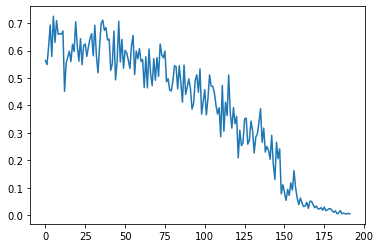

In [64]:
plt.plot(core.OH(x[:192]).detach().numpy()[:,0])

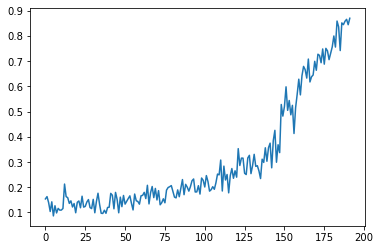

In [65]:
plt.plot(core.OH(x[:192]).detach().numpy()[:,1])

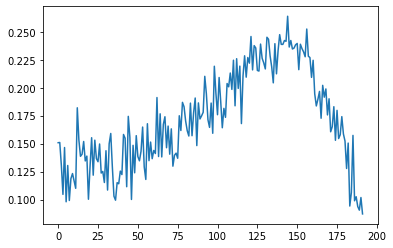

In [62]:
plt.plot(core.OH(x[:192]).detach().numpy()[:,2])

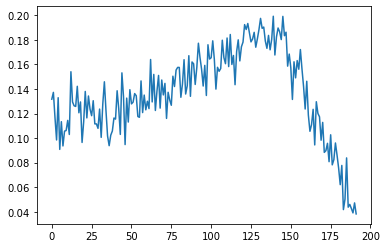

In [63]:
plt.plot(core.OH(x[:192]).detach().numpy()[:,3])